In [67]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [70]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import time  
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [3]:
df_test = pd.read_csv('content/test_mobile.csv')

In [4]:
df_train = pd.read_csv('content/train_mobile.csv')

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   battery_power  1000 non-null   int64  
 2   blue           1000 non-null   int64  
 3   clock_speed    1000 non-null   float64
 4   dual_sim       1000 non-null   int64  
 5   fc             1000 non-null   int64  
 6   four_g         1000 non-null   int64  
 7   int_memory     1000 non-null   int64  
 8   m_dep          1000 non-null   float64
 9   mobile_wt      1000 non-null   int64  
 10  n_cores        1000 non-null   int64  
 11  pc             1000 non-null   int64  
 12  px_height      1000 non-null   int64  
 13  px_width       1000 non-null   int64  
 14  ram            1000 non-null   int64  
 15  sc_h           1000 non-null   int64  
 16  sc_w           1000 non-null   int64  
 17  talk_time      1000 non-null   int64  
 18  three_g  

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
def send_to_telegram(message):
    pass  # Заглушка, имитируем отправку сообщения

In [8]:
# Разделяем признаки и целевой столбец
X = df_train.drop(columns=['price_range'])
y = df_train['price_range']

# Разбиваем данные: 80% в train, 20% в validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df_test.drop(columns=['id'])) 


In [10]:
# Конвертируем в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [11]:
# Создаём Dataset
class MobileDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

# Создаём датасеты
train_dataset = MobileDataset(X_train_tensor, y_train_tensor)
val_dataset = MobileDataset(X_val_tensor, y_val_tensor)  # Для валидации
test_dataset = MobileDataset(X_test_tensor)  # df_test без y

In [12]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
# Определение модели
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=4):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [26]:
# Параметры обучения
num_epochs = 50

# Директория для сохранения моделей
os.makedirs("models", exist_ok=True)

# Определение функций потерь и оптимизаторов
loss_functions = {
    "cross_entropy": nn.CrossEntropyLoss(),
    "nll_loss": nn.NLLLoss()
}

optimizers = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.001),
    "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001),
    "RMSprop": lambda model: optim.RMSprop(model.parameters(), lr=0.001),
    "Adagrad": lambda model: optim.Adagrad(model.parameters(), lr=0.001)
}

# Доступные устройства
devices = {
    "CPU": torch.device("cpu"),
    "GPU": torch.device("cuda") if torch.cuda.is_available() else None
}

# Словарь для хранения результатов
results = []

# Перебираем все комбинации
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_func in optimizers.items():
        for device_name, device in devices.items():
            if device is None:  # Пропускаем GPU, если его нет
                continue

            print(f"\n🔍 Тестируем: {loss_name} + {opt_name} на {device_name}")

            # Инициализируем модель
            model = NeuralNet(input_size=X_train_tensor.shape[1], num_classes=len(y_train.unique())).to(device)

            # Создаём оптимизатор
            optimizer = opt_func(model)

            # Запускаем таймер
            start_time = time.time()

            best_val_loss = float("inf")  # Лучший результат
            best_model_path = f"models/{loss_name}_{opt_name}_{device_name}.pth"

            # Списки для хранения потерь
            train_losses = []
            val_losses = []

            # Early Stopping
            patience = 5  # Количество эпох без улучшений
            best_val_loss = float("inf")
            counter = 0  # Счётчик эпох без улучшения

            # Обучение модели
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0

                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                avg_train_loss = running_loss / len(train_loader)
                train_losses.append(avg_train_loss)

                # Оценка на валидации
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for X_val_batch, y_val_batch in val_loader:
                        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                        outputs = model(X_val_batch)
                        val_loss += criterion(outputs, y_val_batch).item()
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == y_val_batch).sum().item()
                        total += y_val_batch.size(0)

                avg_val_loss = val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

                val_accuracy = correct / total

                # Проверяем early stopping
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    counter = 0  # Сбрасываем счётчик
                    torch.save(model.state_dict(), "best_model.pth")  # Сохраняем лучшую модель
                    print(f"🎯 Новая лучшая модель сохранена: {best_model_path} (Val Loss: {avg_val_loss:.4f})")
                else:
                    counter += 1
                    print(f" Patience {counter}/{patience}")
            
                    if counter >= patience:
                        print("⏹️ Early stopping: валидационный loss не улучшается!")
                        break  # Останавливаем обучение

            # Останавливаем таймер
            end_time = time.time()
            training_time = end_time - start_time

            # Сохраняем результаты
            results.append({
                "loss": loss_name,
                "optimizer": opt_name,
                "device": device_name,
                "val_accuracy": val_accuracy,
                "training_time": training_time,
                "model_path": best_model_path,
                "train_losses": train_losses,
                "val_losses": val_losses
            })

            print(f"✅ Завершено: {loss_name} + {opt_name} на {device_name} | Val Acc: {val_accuracy:.4f} | Time: {training_time:.2f} сек")

# Выводим все результаты
print("\n📊 Итоговые результаты:")
for res in results:
    print(f"{res['loss']} + {res['optimizer']} на {res['device']} | Acc: {res['val_accuracy']:.4f} | Time: {res['training_time']:.2f} сек | Модель: {res['model_path']}")



🔍 Тестируем: cross_entropy + SGD на CPU
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3909)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3895)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3882)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3868)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3854)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3841)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3827)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3814)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3800)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3787)
🎯 Новая лучшая модель сохранена: models/cross_entropy_SGD_CPU.pth (Val Loss: 1.3774)
🎯 Новая лучшая модель со

## Можно сделать несколько выводов:

- Оптимизатор RMSprop показывает лучшие результаты

- RMSprop + cross_entropy показал лучший результат (~94.75%) на CPU/GPU.
- Adam + cross_entropy немного отстал (~93.50%),.
- Adagrad + cross_entropy выступил слабее (~52.75%),скорее всего т.к Adagrad не так эффективен для сложных задач.
- SGD + cross_entropy дал самый слабый результат (~40.50%).

- Для nll_loss:

- Точность всех моделей значительно ниже (~45%)
- SGD + nll_loss вообще провалился (~25%).

GPU всегда показал себя медленнее
Маленькие модели и небольшие батчи — скорее всего небольших сетей загрузка данных на GPU занимает больше времени, чем сам расчет.
Переключение между CPU-GPU — если часть вычислений все еще идет на CPU (например, загрузка данных), это замедляет GPU.
Маленький объем данных — GPU показывает преимущество только на больших наборах данных и глубоких моделях.



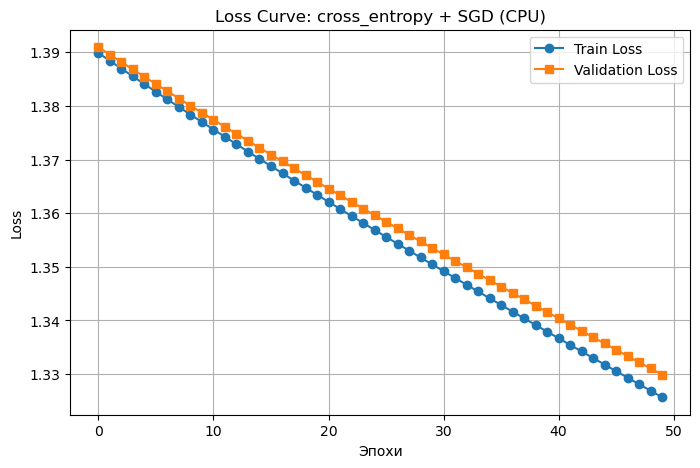

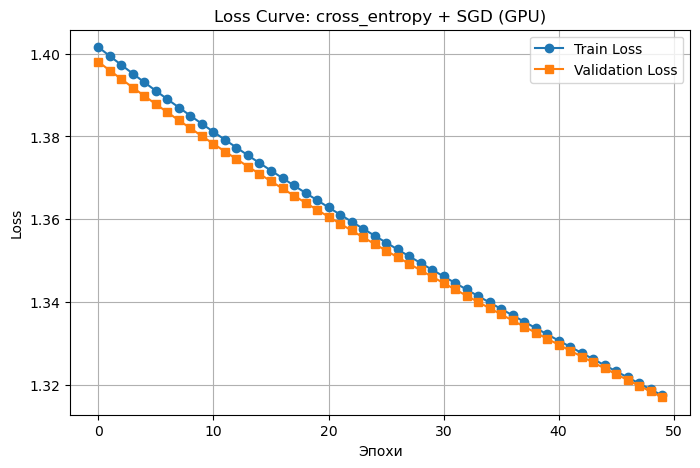

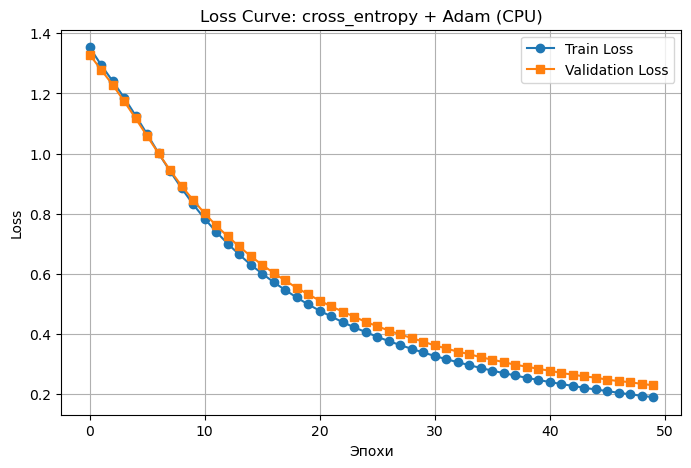

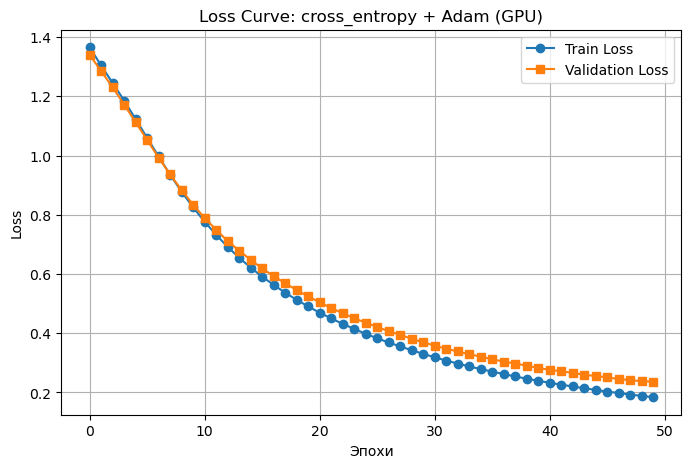

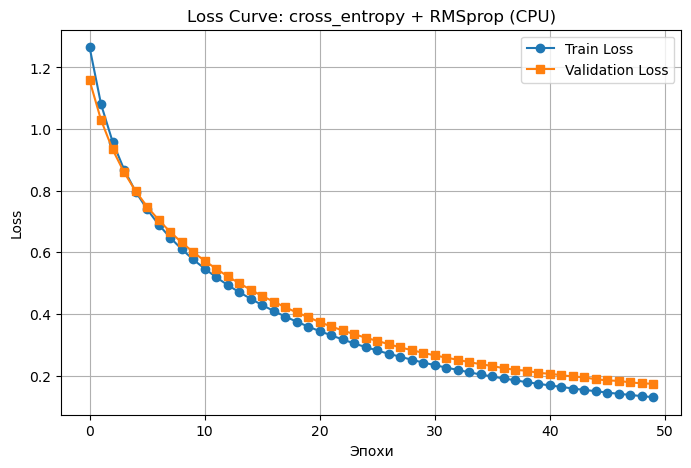

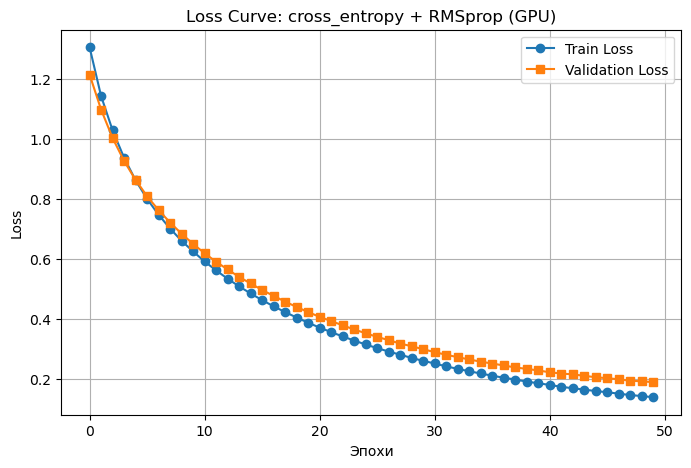

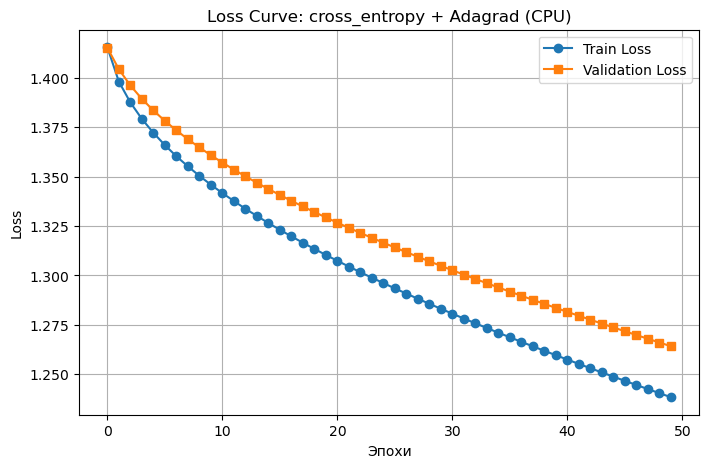

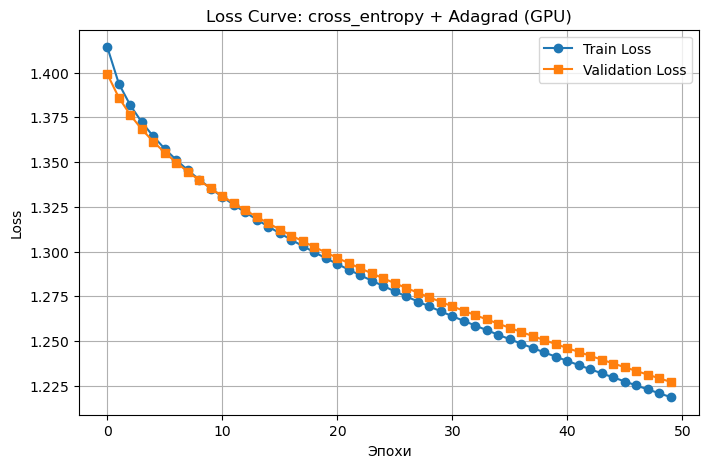

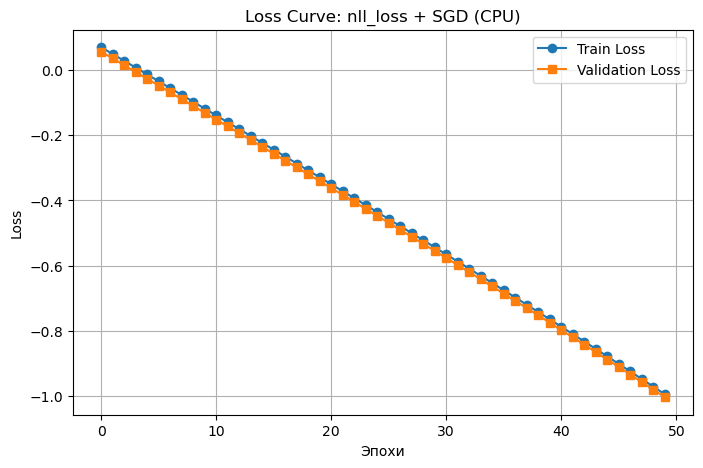

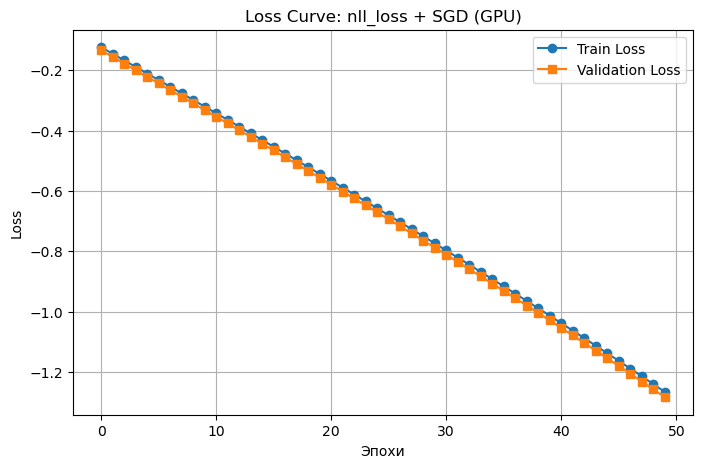

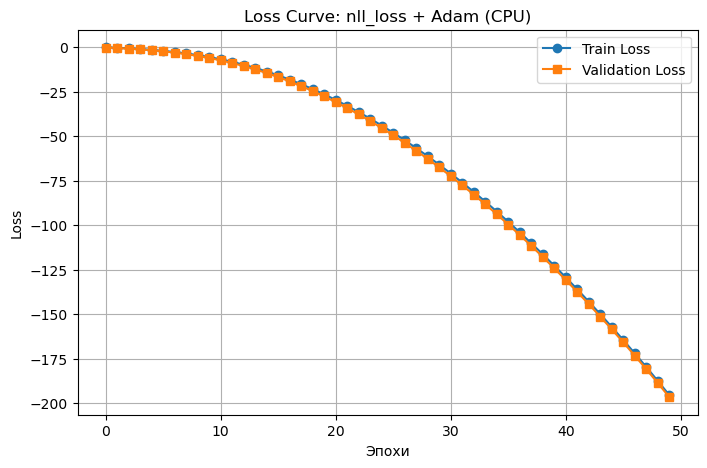

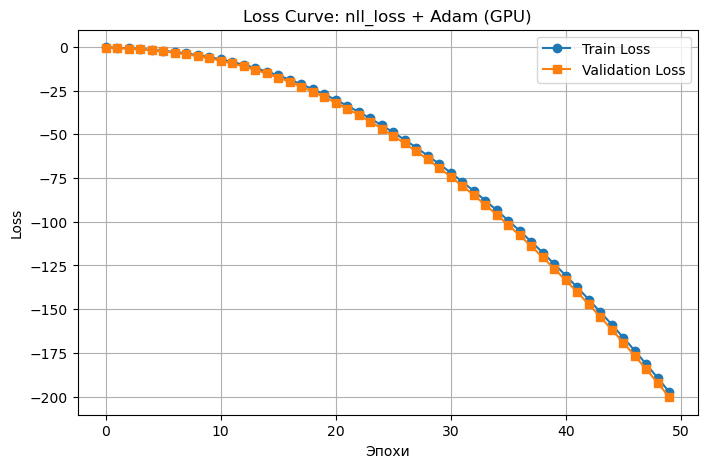

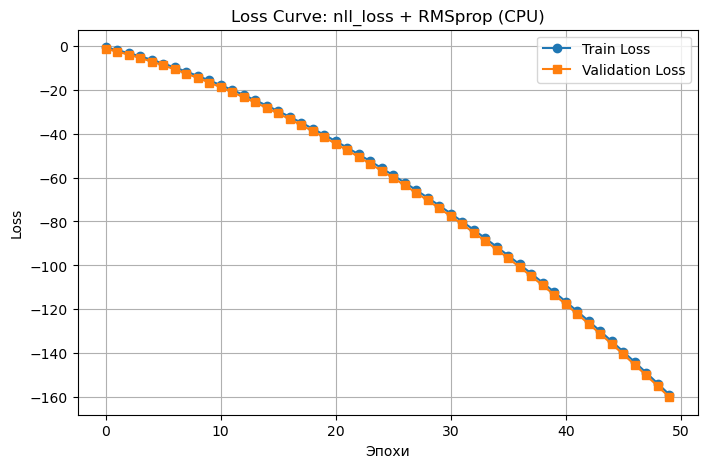

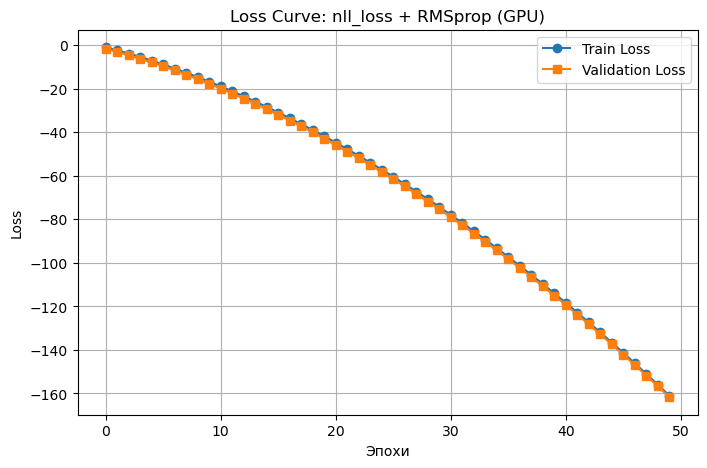

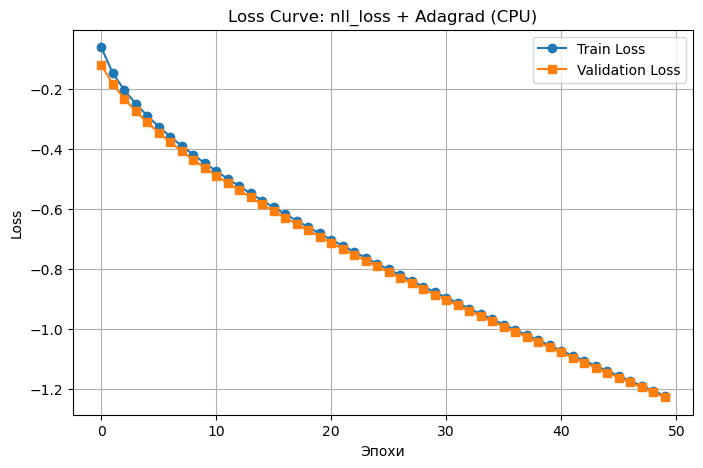

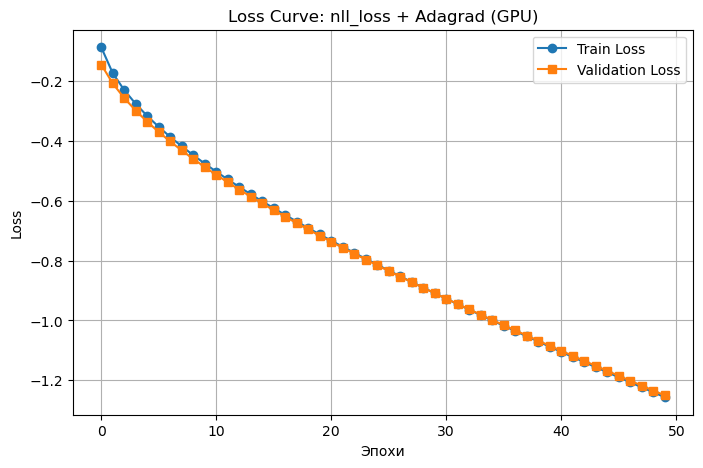

In [27]:
# Графики train_loss и val_loss по эпохам для каждого метода
for res in results:
    plt.figure(figsize=(8, 5))
    plt.plot(res["train_losses"], label="Train Loss", marker="o")
    plt.plot(res["val_losses"], label="Validation Loss", marker="s")
    plt.xlabel("Эпохи")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve: {res['loss']} + {res['optimizer']} ({res['device']})")
    plt.legend()
    plt.grid()
    plt.show()

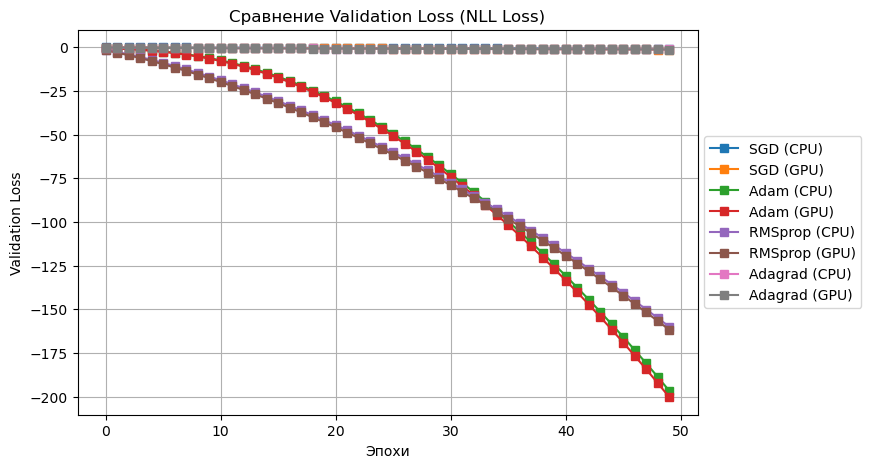

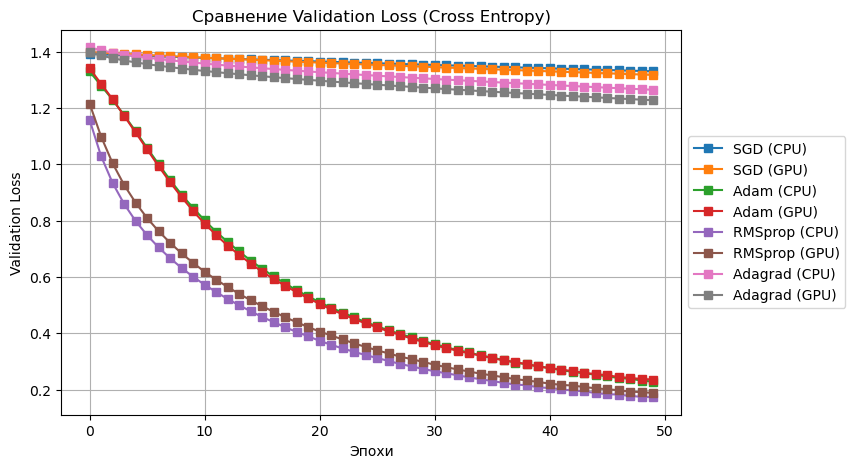

In [28]:
# Фильтрация данных по типу функции потерь
results_nll = [res for res in results if res["loss"] == "nll_loss"]
results_ce = [res for res in results if res["loss"] == "cross_entropy"]

# График для NLL Loss
plt.figure(figsize=(8, 5))

for res in results_nll:
    plt.plot(res["val_losses"], label=f"{res['optimizer']} ({res['device']})", marker="s")

plt.xlabel("Эпохи")
plt.ylabel("Validation Loss")
plt.title("Сравнение Validation Loss (NLL Loss)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Легенда вынесена сбоку
plt.grid()
plt.show()

# График для Cross Entropy Loss
plt.figure(figsize=(8, 5))

for res in results_ce:
    plt.plot(res["val_losses"], label=f"{res['optimizer']} ({res['device']})", marker="s")

plt.xlabel("Эпохи")
plt.ylabel("Validation Loss")
plt.title("Сравнение Validation Loss (Cross Entropy)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Легенда вынесена сбоку
plt.grid()
plt.show()

### Вывод: Нет смысла делать предикты по этим моделям. Мы обучим новую мождель на RSMprop + CrossEntropy с разнымии параметрами. И так как наша функция earlystop ни разу не сработала повысим кол-во epoсh до 100

<a id="save_model_section"></a>

In [33]:
# Параметры обучения
num_epochs = 200

# Директория для сохранения моделей
os.makedirs("models/RMSprop_mobile", exist_ok=True)

# Определение функций потерь и оптимизаторов
loss_functions = {
    "cross_entropy": nn.CrossEntropyLoss()
}

optimizers = {
    "RMSprop_alpha_0.9_momentum_0.0": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.0": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.9": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.9": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.0_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.0, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.0_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.0, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.9_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.9, alpha=0.9),
    "RMSprop_alpha_0.99_momentum_0.9_lr_0.01": lambda model: optim.RMSprop(model.parameters(), lr=0.01, momentum=0.9, alpha=0.99),
    "RMSprop_alpha_0.9_momentum_0.5": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5, alpha=0.9),
    "RMSprop_alpha_0.9_momentum_0.7": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7, alpha=0.9),
    "RMSprop_alpha_0.9_momentum_0.3": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.3, alpha=0.9),
    "RMSprop_alpha_0.8_momentum_0.5": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7, alpha=0.8),
    "RMSprop_alpha_0.85_momentum_0.7": lambda model: optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7, alpha=0.85),
    "RMSprop_alpha_0.9_momentum_0.7_lr_0.0005": lambda model: optim.RMSprop(model.parameters(), lr=0.0005, momentum=0.7, alpha=0.9),
}

# Доступные устройства
devices = {
    # "CPU": torch.device("cpu"),
    "GPU": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
}

# Словарь для хранения результатов
results = []

# Перебираем все комбинации
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_func in optimizers.items():
        for device_name, device in devices.items():
            print(f"\n🔍 Тестируем: {loss_name} + {opt_name} на {device_name}")

            # Инициализируем модель
            model = NeuralNet(input_size=X_train_tensor.shape[1], num_classes=len(y_train.unique())).to(device)

            # Создаём оптимизатор
            optimizer = opt_func(model)

            # Запускаем таймер
            start_time = time.time()

            best_val_loss = float("inf")
            best_model_path = f"models/RMSprop_mobile/{loss_name}_{opt_name}_{device_name}.pth"

            train_losses = []
            val_losses = []

            patience = 5
            counter = 0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0

                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                avg_train_loss = running_loss / len(train_loader)
                train_losses.append(avg_train_loss)

                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for X_val_batch, y_val_batch in val_loader:
                        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                        outputs = model(X_val_batch)
                        val_loss += criterion(outputs, y_val_batch).item()
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == y_val_batch).sum().item()
                        total += y_val_batch.size(0)

                avg_val_loss = val_loss / len(val_loader)
                val_losses.append(avg_val_loss)

                val_accuracy = correct / total

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    counter = 0
                    torch.save(model.state_dict(), best_model_path)
                    print(f"🎯 Лучшая модель сохранена: {best_model_path} (Val Loss: {avg_val_loss:.4f})")
                    send_to_telegram(f"Модель {best_model_path} сохранена и загружена.")  # Отправка модели в телегу
                else:
                    counter += 1
                    if counter >= patience:
                        print("⏹️ Early stopping!")
                        break

            end_time = time.time()
            training_time = end_time - start_time

            results.append({
                "loss": loss_name,
                "optimizer": opt_name,
                "device": device_name,
                "val_accuracy": val_accuracy,
                "training_time": training_time,
                "model_path": best_model_path
            })

            print(f"✅ Завершено: {loss_name} + {opt_name} на {device_name} | Val Acc: {val_accuracy:.4f} | Time: {training_time:.2f} сек")

# Выводим все результаты
print("\n📊 Итоговые результаты:")
for res in results:
    print(f"{res['loss']} + {res['optimizer']} на {res['device']} | Acc: {res['val_accuracy']:.4f} | Time: {res['training_time']:.2f} сек | Модель: {res['model_path']}")



🔍 Тестируем: cross_entropy + RMSprop_alpha_0.9_momentum_0.0 на GPU
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 1.2946)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 1.2363)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 1.1797)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 1.1233)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 1.0680)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 1.0138)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_momentum_0.0_GPU.pth (Val Loss: 0.9613)
🎯 Лучшая модель сохранена: models/RMSprop_mobile/cross_entropy_RMSprop_alpha_0.9_mome

Лучшие модели по точности (Acc)

RMSprop (α=0.8, momentum=0.5)	0.9500	1.17с
RMSprop (α=0.9, momentum=0.5)	0.9475	1.83с
RMSprop (α=0.9, momentum=0.7)	0.9475	1.17с
RMSprop (α=0.9, momentum=0.7, lr=0.0005)	0.9450	1.81с
RMSprop (α=0.9, momentum=0.3)	0.9400	2.63с

Влияние параметров на точность
Momentum=0.5-0.7 дали лучший результат (Acc 0.9475-0.9500).
Уменьшение α=0.8 улучшило точность (0.9500 против 0.9475).
Без momentum (momentum=0.0) модель учится медленно, но результат около 0.9400.
Слишком большой momentum (momentum=0.9) ухудшает точность (до 0.8675).
Высокий lr=0.01 приводит к нестабильности и потере точности.

Лучшие модели по времени 
RMSprop (α=0.9, momentum=0.9, lr=0.01)	0.8675	0.19с
RMSprop (α=0.9, momentum=0.9)	0.9150	0.60с
RMSprop (α=0.9, momentum=0.7)	0.9475	1.17с
RMSprop (α=0.9, momentum=0.5)	0.9475	1.83с
RMSprop (α=0.9, momentum=0.0)	0.9375	3.13с

momentum=0.9 очень быстрый, но точность хуже.
momentum=0.5-0.7 — оптимальный баланс скорости и точности.
momentum=0.0 самый долгий, но дает стабильный результат.

In [38]:
# Выбираем лучшую модель
best_model_res = max(results, key=lambda x: x["val_accuracy"])
best_model_path = best_model_res["model_path"]
best_model_name = f"{best_model_res['loss']}_{best_model_res['optimizer']}_{best_model_res['device']}"

print(f"🏆 Лучшая модель: {best_model_name} с точностью {best_model_res['val_accuracy']:.4f}")

# Загружаем только лучшую модель
models = {}

print(f"🔄 Загружаем модель: {best_model_name}")
model = NeuralNet(input_size=X_train_tensor.shape[1], num_classes=len(y_train.unique()))
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.to(device)  # Перенос модели на тот же девайс, что и данные
model.eval()  # Переключаем в режим предсказания

models[best_model_name] = model  # Оставляем только одну модель


# Делаем предсказания лучшей моделью
predictions_dict = {}

for name, model in models.items():
    print(f"Делаем предсказания моделью: {name}")

    predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)  # Перенос входных данных на GPU
            y_pred = model(X_batch)
            predictions.extend(torch.argmax(y_pred, dim=1).cpu().numpy())  # Перенос результата на CPU перед numpy

    predictions_dict[name] = predictions

# Сохраняем предсказания
df_test[f"price_range_pred_{best_model_name}"] = predictions_dict[best_model_name]
df_test.to_csv("predicted_test.csv", index=False)

print("✅Предсказания сохранены в predicted_test.csv")

🏆 Лучшая модель: cross_entropy_RMSprop_alpha_0.8_momentum_0.5_GPU с точностью 0.9500
🔄 Загружаем модель: cross_entropy_RMSprop_alpha_0.8_momentum_0.5_GPU
🧠 Делаем предсказания моделью: cross_entropy_RMSprop_alpha_0.8_momentum_0.5_GPU
✅ Предсказания сохранены в predicted_test.csv


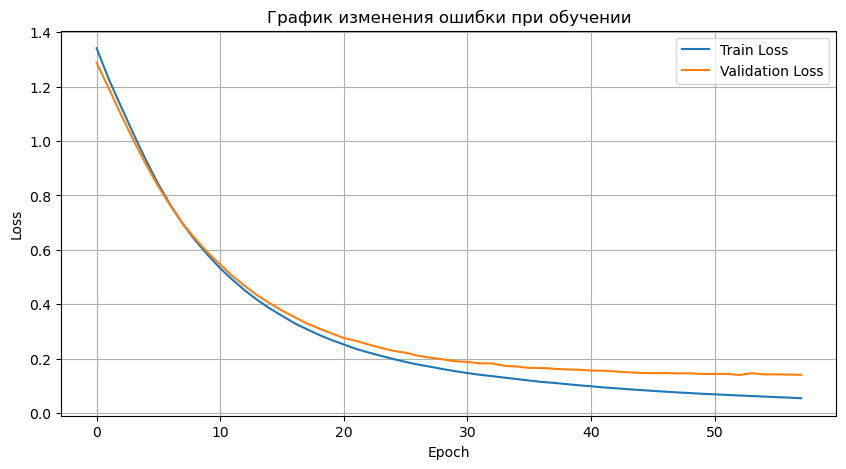

In [79]:
# Построение графика изменения функции потерь
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График изменения ошибки при обучении")
plt.legend()
plt.grid()
plt.show()

<Figure size 800x600 with 0 Axes>

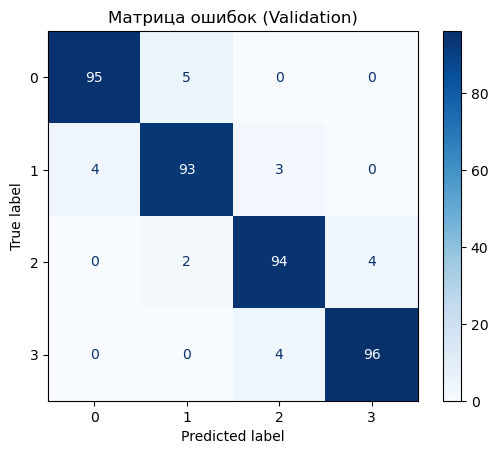

In [80]:
true_labels = []

val_predictions = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())

# Преобразуем в numpy
y_val_numpy = y_val_tensor.numpy()  # Истинные метки
val_predictions_numpy = np.array(val_predictions)  # Предсказания

# Строим матрицу ошибок
cm = confusion_matrix(y_val_numpy, val_predictions_numpy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Рисуем график
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок (Validation)")
plt.show()

### Матрица ошибок показывает очнеь хороший результат.Попробуем сделать кроссвалидацию (Стэкинг) и посомтрим что изменится

In [53]:
# Выбираем топ-3 моделей по val_accuracy
top_3_models = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)[:3]

# Словарь для хранения предсказаний моделей
meta_features_train = []
meta_features_test = []

# Получаем предсказания каждой модели
for model_info in top_3_models:
    model_name = f"{model_info['loss']}_{model_info['optimizer']}_{model_info['device']}"
    
    # Загружаем модель
    model = NeuralNet(input_size=X_train_tensor.shape[1], num_classes=len(y_train.unique()))
    model.load_state_dict(torch.load(model_info["model_path"], weights_only=True))
    model.to(device)
    model.eval()
    
    # Предсказания на валидации
    with torch.no_grad():
        val_preds = model(torch.tensor(X_val_scaled, dtype=torch.float32, device=device))
        val_preds = torch.argmax(val_preds, dim=1).cpu().numpy()
        meta_features_train.append(val_preds)
    
    # Предсказания на тесте
    with torch.no_grad():
        test_preds = model(torch.tensor(X_test_scaled, dtype=torch.float32, device=device))
        test_preds = torch.argmax(test_preds, dim=1).cpu().numpy()
        meta_features_test.append(test_preds)

# Формируем новый обучающий и тестовый набор для метамодели
X_meta_train = np.column_stack(meta_features_train)
X_meta_test = np.column_stack(meta_features_test)

# Обучаем логистическую регрессию
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta_train, y_val)

# Делаем предсказания на тесте
final_predictions = meta_model.predict(X_meta_test)

# Сохраняем предсказания
df_test[f"price_range_pred_meta"] = final_predictions
df_test.to_csv("predicted_test_meta.csv", index=False)

print("✅ Кросс-валидация (стэкинг) завершена, предсказания сохранены в predicted_test_meta.csv")


✅ Кросс-валидация (стэкинг) завершена, предсказания сохранены в predicted_test_meta.csv


Ensemble Model Accuracy: 95.00%


<Figure size 800x600 with 0 Axes>

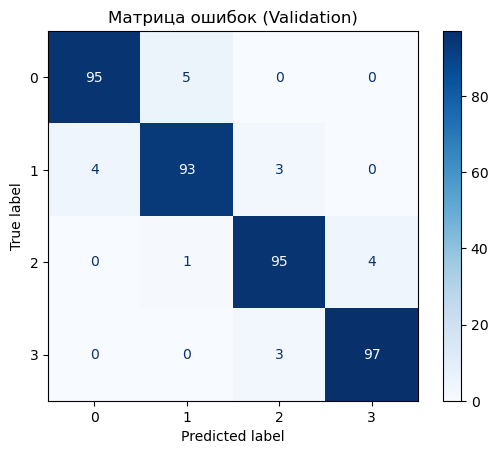

Ensemble Model F1 Score: 0.95


In [66]:
val_predictions_meta_numpy = meta_model.predict(X_meta_train)
# Рассчитываем точность ансамблированной модели
accuracy = accuracy_score(y_val_numpy, val_predictions_meta_numpy)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")

# Матрица ошибок
cm = confusion_matrix(y_val_numpy, val_predictions_meta_numpy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Рисуем график
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок (Validation)")
plt.show()
# F1 score
f1 = f1_score(y_val_numpy, val_predictions_meta_numpy, average='weighted')
print(f"Ensemble Model F1 Score: {f1:.2f}")



### Вывод: можели скорее всего слищком похожи, поэтому метамодель не получает дополнительной информации и просто повторяет лучшую из них.

## Теперь попробуем построить модели с помощью tensorflow

### Вначале используем данные оптимизатора и loss -лучшие полученные в pytorch

In [90]:
# Директория для сохранения моделей
os.makedirs("models/keras_mobile", exist_ok=True)

# Создаем функцию для создания модели
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Входной слой
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')  # 4 класса (цифры 0-3)
    ])
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.5, rho=0.8),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Функция для обучения модели на определенном устройстве (CPU или GPU)
def train_on_device(device):
    with tf.device(device):
        print(f"Обучение модели на {device}...")
        model = create_model()

        # Функции callbacks
        callbacks_filtered = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ModelCheckpoint('models/keras_mobile/best_model.keras', monitor='val_loss', save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ]
        
        # Запускаем обучение и измеряем время
        start_time = time.time()
        history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=64, 
                            validation_data=(X_val_scaled, y_val), 
                            callbacks=callbacks_filtered, verbose=1)
        end_time = time.time()

        # Возвращаем время, потраченное на обучение
        training_time = end_time - start_time

        send_to_telegram(f" Модель  обучена и сохранена в models/keras_mobile/best_model.keras")
        return training_time, history

models_keras = {}

# Обучение модели на CPU и сохранение в словарь
cpu_device = '/CPU:0'
cpu_training_time, cpu_history = train_on_device(cpu_device)
models_keras['cpu'] = create_model()  # Создаем новую модель
models_keras['cpu'].set_weights(cpu_history.model.get_weights())  # Загружаем обученные веса
print(f"Время обучения на CPU: {cpu_training_time:.2f} секунд")

# Обучение модели на GPU и сохранение в словарь (если доступен GPU)
if tf.config.list_physical_devices('GPU'):
    gpu_device = '/GPU:0'
    gpu_training_time, gpu_history = train_on_device(gpu_device)
    models_keras['gpu'] = create_model()
    models_keras['gpu'].set_weights(gpu_history.model.get_weights())
    print(f"Время обучения на GPU: {gpu_training_time:.2f} секунд")
else:
    print("GPU не доступен для обучения.")

Обучение модели на /CPU:0...
Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4177 - loss: 1.2324 - val_accuracy: 0.6925 - val_loss: 0.8337 - learning_rate: 0.0010
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7609 - loss: 0.7119 - val_accuracy: 0.8450 - val_loss: 0.5133 - learning_rate: 0.0010
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8841 - loss: 0.4287 - val_accuracy: 0.9000 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9180 - loss: 0.2980 - val_accuracy: 0.9050 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9467 - loss: 0.2085 - val_accuracy: 0.9275 - val_loss: 0.2132 - learning_rate: 0.0010
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9597 - loss: 0.1593 - val_accuracy: 0.9200 - val_loss: 0.1932 - learning_rate: 0.0010
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

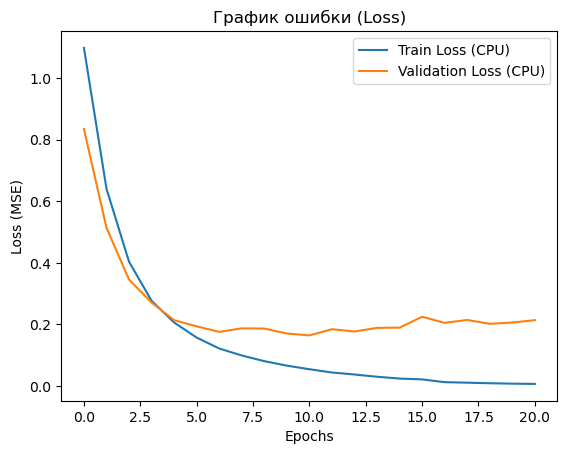

In [91]:
# График ошибки для CPU
plt.plot(cpu_history.history['loss'], label='Train Loss (CPU)')
plt.plot(cpu_history.history['val_loss'], label='Validation Loss (CPU)')

# График ошибки для GPU
if 'gpu_history' in locals():  # Проверим, была ли обучена модель на GPU
    plt.plot(gpu_history.history['loss'], label='Train Loss (GPU)')
    plt.plot(gpu_history.history['val_loss'], label='Validation Loss (GPU)')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


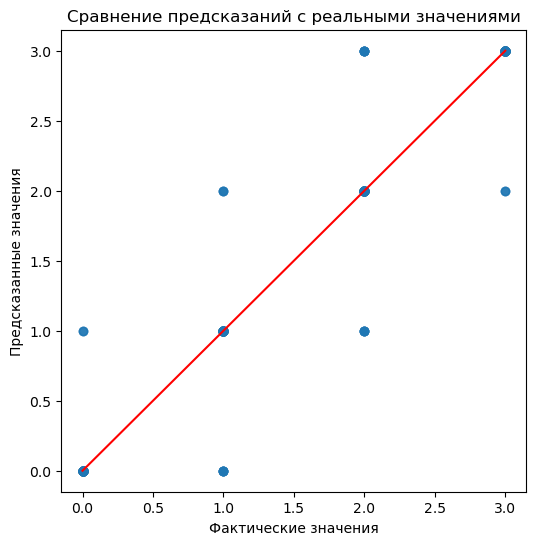

In [93]:
# Выбираем модель, например, обученную на CPU
model = models_keras['cpu']

# Получаем предсказания
y_pred = model.predict(X_val_scaled)
y_pred = np.argmax(y_pred, axis=1)  # Переводим вероятности в классы

# Построим scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')  # Линия идеального предсказания
plt.show()

<Figure size 800x600 with 0 Axes>

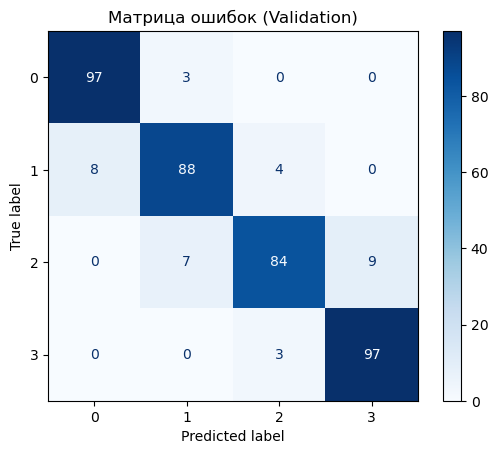

In [95]:
# Построим confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок (Validation)")
plt.show()


In [96]:
# F1 score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Ensemble Model F1 Score: {f1:.2f}")


Ensemble Model F1 Score: 0.91


## Выводы: У TensorFlow-модели точность -1,  но  Ensemble Model F1 Score: 0.91 т.е по факту точность можели всеже ниже чем на pytorch  т.к там RMSprop точность -0.9500,  но Ensemble Model F1 Score: 0.95. Почему F1-score ниже у TensorFlow-модели?
Overfitting (переобучение)

accuracy: 1.0000 на обучении → слишком низкий loss говорит, что модель, возможно, переобучилась.
val_accuracy: 0.9200, val_loss: 0.2133 → явно хуже, чем PyTorch (0.95 на валидации).
F1-score показывает реальную эффективность

Ensemble Model F1 Score: 0.91 (TensorFlow)
Ensemble Model F1 Score: 0.95 (PyTorch)
- Значит, модель в TensorFlow на валидации предсказывает хуже, чем PyTorch, несмотря на 100% точность на трейне.

## Сравнение Pytorch и TensorFlow (сделать ссылками на код не получилось, пришлось код копировать)

### 1. Отладка/дебаг/собственный функции

1.1 Pytorch

Мы можем вставть нужную нам функцию и/или дебаг в нужное нам место кода (хоть в середину обучения).
Например: 
if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    counter = 0
    torch.save(model.state_dict(), best_model_path)
    print(f"🎯 Лучшая модель сохранена: {best_model_path} (Val Loss: {avg_val_loss:.4f})")
    send_to_telegram(f"Модель {best_model_path} сохранена и загружена.")  # Отправка модели в телегу

1.2 TensorFlow

Можно вставить только вне основного графа.
Например:
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=64, 
                            validation_data=(X_val_scaled, y_val), 
                            callbacks=callbacks_filtered, verbose=1)
        end_time = time.time()
        training_time = end_time - start_time
        send_to_telegram(f" Модель  обучена и сохранена в models/keras_mobile/best_model.keras")

Т.е мы не можем как в случае с Pytorch вставить нужную нам функцию в callbacks

### 2. Коробочные функции

2.1 Pytorch

Мало реализованных функций. Но их можно напистаь самому(что сложнее испольозования коробочных функций). 

Например:
Вызов расчета предикта

predictions_dict = {}

for name, model in models.items():
    print(f" Делаем предсказания моделью: {name}")

    predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)  # Перенос входных данных на GPU
            y_pred = model(X_batch)
            predictions.extend(torch.argmax(y_pred, dim=1).cpu().numpy())  # Перенос результата на CPU перед numpy

    predictions_dict[name] = predictions

2.2 TensorFlow

Много коробочных функций. Т.е очнеь легко применять.

Например:
Вызов расчета предикта
test_loss_filtered_all, test_mae_filtered_all = model_filtered_all.evaluate(
    X_val_scaled_filtered_all, y_val_filtered_all, verbose=1)

### 3. Изменение архитектуры

3.1 Pytorch

Можно добавить слой в уже существующу модель (т.е можно менять архитекутуру на лету)
model.fc = Sequential(model.fc, nn.ReLU(), nn.Linear(64, 32))

3.2 TensorFlow

Можно только создать новую модель скопировов старую и заменив/добавив нужный слой.
new_model = tf.keras.Sequential(old_model,tf.keras.layers.Dense(32, activation='relu'))